In [174]:
#As always, we import everything
import pandas as pd
import os
import re
import hdf5_getters as getters
import requests
from bs4 import BeautifulSoup
import numpy as np
from collections import OrderedDict
from tqdm import tqdm
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from collections import Counter
from textblob import Word
import pycountry
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from gensim import corpora, models
import matplotlib as plt
import json
import pickle
import lyricfetcher
import csv
import urllib
from urllib.request import urlopen, HTTPError

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to C:\Users\Arthur
[nltk_data]     Parmentier\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Arthur
[nltk_data]     Parmentier\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [175]:
data_dir = './' + 'data'

# README

For the data collection, we have based ourselves on the Million Song Dataset. From this huge data, we are only interested in four attributes:
- The track id
- The artist name
- The year
- The title

In addition to that, we are also interested in the genre of the songs. Luckily, in the Million Song Dataset website, there is already a dataset with the track id and the genre. Thus, we downloaded the corresponding file. We have the genre information for around 191'000 songs. Moreover, we have direct access to the 4 attributes through an additional dataset of around 500'000 songs provided in the Million song website. 

We decide to limit our analysis on this dataset for two reasons. First, manipulating the whole million songs dataset is both time consuming and would require the use of the cluster. Second, after a fast and simple instruction, we discovered that around 150'000 of the genre id are already in the subset we have found.

Next, we use some APIs to scrap and collect the lyrics on several websites. However, we could not scrape all of our dataset so far, as one scraping operation takes more than 1 second. The whole scraping of the full set would take more than 55 hours, so we will have to find a method to perform it. The success rate of the scraping code on the 200 more recent songs of the data set was 129/200, which is fair but can still be raised by doing more string processing, for instance removing the "(live)" or "(album version)" strings. For the oldest songs, the success of the scraping is near 0, as the old songs are not usually found in the lyrics websites. This is not a major problem since as shown in our analysis later, the vast majority of the songs are recent ones.
Alternatively, we can use an additional dataset from the million song website containing bag of words data. We would like to avoid this alternative as it is a simple count of words in the songs and it removes them from the context in the songs.

In our notebook, we have performed a first descriptive analysis of the merged datasets. The big proportion ( 41%) of the songs' genre is rock. Moreover, although the values of the year attribute range from 1920 to 2010, 91% of the tracks are from the 1980 to 2010. We believe this is due to the rapid growth of Rock from its birth in the fifties to achieve more than 50% of the music industry in the 70s to 80s. In our notebook, we have a plot showing this evolution. In our analysis, due to the genre unbalance, we will use a random subset of the rock music ( or the decade) to balance out the classes.

# Data Collection and Descriptive Analysis

Using an additional dataset obtained from the million song website that contains genre information, we created genre_dataset. This dataset contains genre information for 191401 songs. The cell below contains code for putting this data into a proper-formatted dataframe. Another helpful dataset obtained from the website of million song dataset is one that contains year the track was released. In addition to year, it also contains track_id, the name of the artist, and title of the track. This dataset contains 515576 data points. Since we wanted to analyze the progression of feminism through lyrics over time, and we were also interested in how women were portrayed in different genres of music, we decided to take the intersection of these datasets (inner join on track ID), and the resulting data frame contains 152793 data points. We save it to a csv file for accessing in the future. 

In [202]:
# Resulting Dataset
year_artist_name_title_genre = pd.read_csv(os.path.join(data_dir + "/year_artist_name_title_genre.csv")).set_index('track_id')
year_artist_name_title_genre.head()

,year,artist_name,title,genre
track_id,,,,
TRSGHLU128F421DF83,1922,alberta hunter,don't pan me,Blues
TRRAHXQ128F42511FF,1922,barrington levy,looking my love,Reggae
TRFAFTK12903CC77B8,1922,barrington levy,warm and sunny day,Reggae
TRTRKSF12903CFEDD7,1924,vernon dalhart,wreck of the old 97,Country
TRQYSYF128F935F350,1925,bessie smith,careless love blues,Blues


In [150]:
year_artist_name_title_genre.isna().sum()

year           0
artist_name    0
title          0
genre          0
dtype: int64

No missing values !

We are interested in seeing how many songs are present in each genre. 

In [151]:
print(year_artist_name_title_genre['genre'].value_counts())

# Visualizing the count using bar graph
value_count_by_genre = year_artist_name_title_genre['genre'].value_counts().plot(kind = 'bar')
value_count_by_genre

Rock          62344
Electronic    18043
Pop           11058
Jazz          10662
Rap            8156
Metal          8035
RnB            7692
Country        6652
Reggae         5475
Blues          4228
Folk           3484
Punk           2739
Latin          1954
World          1384
New Age         887
Name: genre, dtype: int64


In [152]:
# Percentage of rock songs in the dataset

round(100*year_artist_name_title_genre['genre'].value_counts()['Rock']/year_artist_name_title_genre['genre'].value_counts().sum(),3)

40.803

We see an abundance of Rock music in this dataset as close to half of the songs (40.8 %) present are labelled as Rock music. We wonder why that is. Is Rock Music more likely to get labelled? (<- this is a joke). We suspect that this is due to the fast growth of Rock music during the 1990s and 2000s. We will explore the relationship between year and genre of music further to confirm our hypothesis. 

Let us first have a look at the count of music by time. Since it is impossible to visualize the count for every single year, we first group years into decades. Upon quick analysis we realize that the dataset contains music up to the year 2010. We consider 2010 a part of the 2000s. 

In [153]:
# create decade column
year_artist_name_title_genre['decade'] = (year_artist_name_title_genre['year'] // 10) * 10

# include year 2010 in the 2000s decade
year_artist_name_title_genre['decade'] = np.where(year_artist_name_title_genre.year.isin(['2010']),'2000', 
                                                  year_artist_name_title_genre['decade'])

In [154]:
round(100*(year_artist_name_title_genre['decade'].value_counts()['2000'] + \
year_artist_name_title_genre['decade'].value_counts()['1990'] + \
year_artist_name_title_genre['decade'].value_counts()['1980']) / \
year_artist_name_title_genre['decade'].value_counts().sum(),3)

91.361

91% of the tracks are from the eighties to 2010

2000    89699
1990    36693
1980    13201
1970     8340
1960     3580
1950      944
1940      138
1930      111
1920       87
Name: decade, dtype: int64


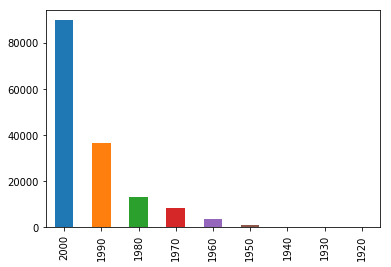

In [155]:
# plot count using bar plot
value_count_by_year = year_artist_name_title_genre['decade'].value_counts().plot(kind = 'bar')

print(year_artist_name_title_genre['decade'].value_counts())
value_count_by_year

We see that there are very few data points earlier than 1970, which makes analysis over time biased. During the next few steps as we explore the relationship between genre and decade further, we only consider the time period of 1970 to 2010. 

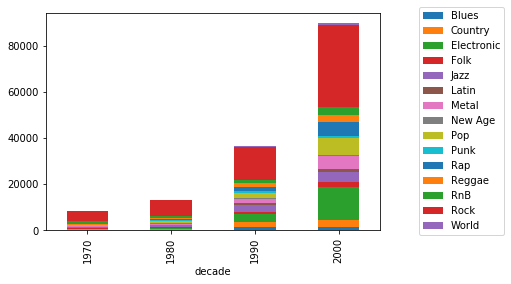

In [156]:
decade_genre = year_artist_name_title_genre[['decade', 'genre']].reset_index()

decade_genre = decade_genre.loc[decade_genre['decade'].isin(['1970','1980','1990','2000'])]

#print(decade_genre.groupby(['decade', 'genre']).size())
plot_decade_genre = decade_genre.groupby(['decade', 'genre']).size().unstack().plot(kind='bar', stacked = True)
plot_decade_genre.legend(bbox_to_anchor=(1.1, 1.05) )


We see that Rock music grew significantly in 40 years. Rock, Electronic, and Pop are the most popular music during the 2000s, followed by metal and Rap. The next plot considers the genres individually, and illustrates their share in the music market over the period of 1970 to 2010. 

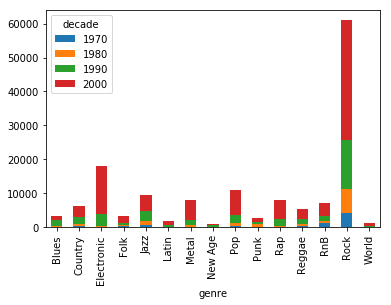

In [157]:
#print(decade_genre.groupby(['genre', 'decade']).size())
decade_genre.groupby(['genre', 'decade']).size().unstack().plot(kind='bar', stacked = True)

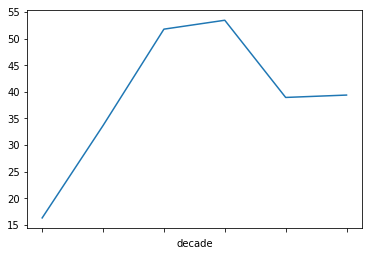

In [158]:
# Evolution of Rock

decade_rock = year_artist_name_title_genre.groupby(['genre','decade']).size()
(100*decade_rock['Rock']/(year_artist_name_title_genre.groupby('decade').size())).plot()


The plot is a bitt hard to read. The curve represents the percentage of rock tracks in our dataset through time. We can clearly see that it has increased drastically from the 60s to 2010. We believe that the slight decrease from 90s is due to the increasing success of RNB, rap, pop and Electronic music during that period.

In [159]:
100*decade_rock['Rock']/(year_artist_name_title_genre.groupby('decade').size())

decade
1920          NaN
1930          NaN
1940          NaN
1950    16.313559
1960    33.659218
1970    51.762590
1980    53.435346
1990    38.936582
2000    39.383940
dtype: float64

# Using the Bag of words model from musicXmatch

In [160]:
# We read the text file line by line 

with open(os.path.join(data_dir, 'mxm_dataset_train.txt')) as f:
    lines = f.readlines()

FileNotFoundError: [Errno 2] No such file or directory: './data\\mxm_dataset_train.txt'

In [ ]:
# The 5'000 most used words sorted by overall occurences are in the 18th line. 
# We split the words by ',' to have a list of words

words = lines[17][1:]
words = words.split(',')

In [ ]:
words[0:4]

Now, for the rest of the file, we have, for each line, a track id and a list of tuplets. A tuplet ( key:value) consists of:
 - a key ( a number ) which represents the identifier of the word ( 1 means the 1st word in our words list etc ).
 - a value which is the occurences of the word in the track.
 
In the following cells, we extract this information and we change the numbered keys to "word keys"

In [ ]:
# First, we split to have a list of tracks

bow = lines[18:]
for i in range(0,len(bow)):
    bow[i] = bow[i].split(',')

In [ ]:
# Uncomment this cell to have a look at the split data
# Warning, it takes a lot of space in the cell

# bow[1:4]

For each track in bow and for each tuplet in the track, extract the key ( the numbers before ':') then replace it by the corresponding word

In [ ]:
for i in range(0,len(bow)):
    for j in range(2,len(bow[i])):
        '''
        For each track in bow and for each tuplet in the track, extract the key ( the numbers before ':')
        then replace it by the corresponding word
        '''
        key = bow[i][j][ 0 : bow[i][j].find(':') ]
        bow[i][j] = bow[i][j].replace(key,words[int(key)-1])
    # The last tuplet in each track has a line skip special character.
    # The next code will take the last tuplet with the special character
    bow[i][len(bow[i])-1] = bow[i][len(bow[i])-1][0:len(bow[i][len(bow[i])-1])-1]

In [ ]:
# Extract the track id 

track_id = []
for i in range(0, len(bow)):
    track_id.append(bow[i][0])

# Lyrics scrapping code

In [176]:
def scrape_lyrics(artists_list,songs_list):
    '''
    Main scrapping function
    Input: lists of songs and their artists names 
    Output: list of lyrics of the songs and list of songs for which the scrapping did not succeed
    In case the scrapping failed, lyrics are returned as empty strings
    
    The lyrics are scrapped from several websites:
    - metrolyrics
    If failed:
    -azlyrics
    If failed also:
    - lyricswikia
    And if it also failed:
    - through the herokuapp online API (unknown source)
    
    '''
    
    lyrics_not_found = []
    if (len(artists_list) == 0 or len(songs_list) == 0):
        raise ValueError('The provided artists list or songs list is empty')
        
    elif (len(artists_list) != len(songs_list)):
        print("artist list has len: ", len(artists_list))
        print("songs list has len: ", len(songs_list))
        raise ValueError('The provided artists and songs lists have different lenghts')
        
    else:
        lyrics = []
        
        for i in tqdm(range(len(artists_list))):
            
            try:
                lyrics_metro = str(lyricfetcher.get_lyrics('metrolyrics',artists_list[i],songs_list[i]))
                lyrics_metro = re.sub(r'[\[].*?[\]]', '', lyrics_metro.replace('\n', ' '))
                lyrics_metro = re.sub(',', '', lyrics_metro)

                if (lyrics_metro == "" or len(lyrics_metro.split())<3):
                    lyrics_az = str(lyricfetcher.get_lyrics('azlyrics',artists_list[i],songs_list[i]))
                    lyrics_az = re.sub(r'[\[].*?[\]]', '', lyrics_az.replace('\n', ' '))
                    lyrics_az = re.sub(',', '', lyrics_az)

                    if (lyrics_az == "" or len(lyrics_az.split())<3):
                        lyrics_wikia = str(lyricfetcher.get_lyrics('lyricswikia',artists_list[i],songs_list[i]))
                        lyrics_wikia = re.sub(r'[\[].*?[\]]', '', lyrics_wikia.replace('\n', ' '))
                        lyrics_wikia = re.sub(',', '', lyrics_wikia)
                        
                        if (lyrics_wikia == "" or len(lyrics_wikia.split())<3):
                            try:
                                lyrics_herokuapp = json.load(urllib.request.urlopen('http://lyric-api.herokuapp.com/api/find/' 
                                                                                + artists_list[i].replace(' ', '%20') + '/' 
                                                                                + songs_list[i].replace(' ', '%20') + '.html'))['lyric']
                            except HTTPError:
                                lyrics_herokuapp = ''
                                
                            lyrics_herokuapp = re.sub(r'[\[].*?[\]]', '', lyrics_herokuapp.replace('\n', ' '))
                            lyrics_herokuapp = re.sub(',', '', lyrics_herokuapp)
                            
                            if (lyrics_herokuapp == "" or len(lyrics_herokuapp.split())<3):
                                lyrics.append("")
                                raise ValueError('No lyrics OR lyrics smaller or equal to 2 words found')
                                
                            else:
                                lyrics.append(lyrics_herokuapp)
                        else:
                            lyrics.append(lyrics_wikia)
                    else:
                        lyrics.append(lyrics_az)

                else:
                    lyrics.append(lyrics_metro)
                    
            except ValueError:
                lyrics_not_found.append([artists_list[i],songs_list[i]])
                continue
    return lyrics, lyrics_not_found

In [177]:
# compute list 'difference' in the sense of objects that are present in one list but not in the other one
def diff(li1, li2): 
    return (list(set(li1) - set(li2))) 

In [181]:
def create_BOW_lyrics_dataframe(artists_to_scrape, titles_to_scrape, dataframe_csv_file_name):

    if any("," in s for s in titles_to_scrape):
        s.replace(",", "")
    
    if any("," in s for s in artists_to_scrape):
        s.replace(",", "")
    
    # The line below calls the scrapping function
    lyrics, lyrics_not_found_list = scrape_lyrics(artists_to_scrape, titles_to_scrape)

    # Prints relevant information
    print(lyrics_not_found_list)
    print('Count of not found lyrics : ' + str(len(lyrics_not_found_list)))
    
    # Tokenize and stem the lyrics

    tokenized_lyrics = []
    for lyrics in lyrics:
        tokens = nltk.word_tokenize(lyrics)
        stemmed_tokens = [ps.stem(token) for token in tokens] 
        tokenized_lyrics.append(stemmed_tokens)

    lyrics_df = pd.DataFrame({'Artists': artists_to_scrape,
                                    'Titles': titles_to_scrape,
                                    'Lyrics(BOW)': tokenized_lyrics
                                   })

    # Save the stemmed version of the lyrics with title and artist to csv

    lyrics_df.to_csv(os.path.join(data_dir + dataframe_csv_file_name)) # Comment/uncomment when saving is needed
    
    return lyrics_df

## Create positive, feminist playlist dataframe

In [188]:
#Provide BELOW the full set of tracks you would like to get in final (XXX_to_scrape)
#-----------------------------------------------------------------------------
artists_to_scrape = ["Sugababes","Helen Reddy","Gwen Guthrie","Jennifer Lopez","Tinashe","Sheryl Crow","Lisa Stansfield",
                     "Ethel Merman", "Hole", "Geri Halliwell","Hole","Christina Aguilera","Shakira","Cardi B","Destiny's Child",
                    "Meredith Brooks","Lupe Fiasco","Little Mix","Iggy Azalea","Lady Gaga","Fifth Harmony","Kelis","Peaches",
                   "Ariana Grande","Tupac Shakur","Alexandra Burke","La Roux"]
titles_to_scrape = ["About a Girl", "Ain't No Way to Treat a Lady","Ain't Nothin' Goin' On but the Rent","Ain't Your Mama",
                    "All Hands on Deck", "All I Wanna Do", "All Woman","Anything You Can Do (I Can Do Better)",
                    "Asking for It"]

titles_to_scrape += ["Bag It Up",
"Be a Man",
"Beautiful",
"Beautiful Liar",
"Bickenhead",
"Bills Bills Bills",
"Bitch",
"Bitch Bad",
"Black Magic",
"Black Widow",
"Born This Way",
"Boss",
"Bossy",
"Boys Wanna Be Her",
"Break Free",
"Brenda's Got a Baby",
"Broken Heels",
"Bulletproof"]

artists_to_scrape += ["Blondie","Christina Aguilera","Kelly Clarkson","All Saints",
                      "i5","Kelly Rowland", "Remy Ma","Demi Lovato","Janet Jackson","Tori Amos",
                     "TLC",]
titles_to_scrape += ["Call Me", 
"Can't Hold Us Down",
"Catch My Breath",
"Chick Fit",
"Cinderella", 
"Commander",
"Conceited", 
"Confident", 
"Control", 
"Cornflake Girl",
"Creep"]

artists_to_scrape += ["Patti Smith","2Pac","Hole","Beyonce","Janelle Monae","Jessie J","Aretha Franklin",
                     "Mary J. Blige","Chris Janson","Babes in Toyland", "Janelle Monae", "Madonna","Christina Aguilera",
                     "Drake","Janet Jackson","Shane McAnally","Bomshel","Christina Aguilera",
                     "Beyonce","Queenadreena","Kacey Musgraves","Nina Simone"]
titles_to_scrape += ["Dancing Barefoot","Dear Mama","Dicknail","Diva","Django Jane",
                    "Do It like a Dude",
                    "Do Right Woman Do Right Man","Doubt","Drunk Girl","Dust Cake Boy","Electric Lady", 
                    "Express Yourself", "Fall in Line","Fancy","Feedback","Female","Fight Like a Girl",
                     "Fighter","Flawless","FM Doll","Follow Your Arrow","Four Women"]

artists_to_scrape += ["Lady Gaga","Lykke Li","Destiny's Child","Maddie & Tae","Alicia Keys",
                     "Cyndi Lauper","Mary Chapin Carpenter","Ariana Grande","Ashanti","Little Mix",
                     "Robyn","Lily Allen","Mary Chapin Carpenter", "Katy Perry",
                     "David Guetta", "Blu Cantrell", "Gwen Stefani", "Madonna", "Pussycat Dolls",
                     "Jordin Sparks","Kelly Clarkson","Kelly Clarkson","Amil","Christina Aguilera",
                     "Icona Pop", "Gloria Gaynor","Diana Ross","Chaka Khan", "Beyonce","Martina McBride",
                     "Destiny's Child","Beyonce","Whitney Houston","Little Mix","Madonna","No Doubt","2Pac","Christina Aguilera",
                     "TLC","Sonic Youth","Vera Blue","Lush"]
titles_to_scrape += ["G.U.Y.","Get Some","Girl","Girl in a Country Song",
                     "Girl on Fire","Girls Just Want to Have Fun","Girls with Guitars",
                     "God Is a Woman","Good Good","Hair","Handle Me","Hard out Here",
                     "He Thinks He'll Keep Her","Hey Hey Hey","Hey Mama", 
                     "Hit 'Em Up Style (Oops!)","Hollaback Girl","Human Nature","Hush Hush; Hush Hush",
                     "I Am Woman","I Do Not Hook Up",
                     "I Don't Think About You","I Got That","I Hate Boys",
                     "I Love It", "I Will Survive","I'm Coming Out","I'm Every Woman",
                     "If I Were a Boy","Independence Day","Independent Women",
                     "Irreplaceable",
                     "It's Not Right but It's Okay","Joan of Arc","Jump",
                     "Just a Girl","Keep Ya Head Up", "Keeps Gettin' Better", "Kick Your Game","Kool Thing",
                    "Lady Powers","Ladykillers"]

artists_to_scrape += ["Kesha", "Sugarcubes","Idina Menzel","Miley Cyrus","Ciara","Alesha Dixon","Beyonce",
                      "Manic Street Preachers", "Little Mix","Jennifer Lopez","Nicki Minaj","K.Michelle",
                     "Hailee Steinfeld","Zara Larsson","Shania Twain","Cicely Hamilton","Selena Gomez","Beyonce",
                      "Kelly Clarkson","Hailee Steinfeld","Janet Jackson","Dua Lipa","Drake","Meghan Trainor",
                      "Lil B","Barbra Streisand","TLC","Franz Ferdinand","Salt-n-Pepa","Doubleclicks","Mariah Carey",
                      "X-Ray Spex","Tweet","Madonna","Brooke Candy","Katy Perry","Jodi Benson","Beyonce","Nervo",
                      "Taylor Swift","Loretta Lynn","Nirvana","Little Mix","L7","Maggie Lindemann","Keri Hilson",
                      "Britney Spears","Beyonce","Marina and the Diamonds","Janelle Monae"
                     ]
titles_to_scrape += ["Learn to Let Go","Leash Called Love","Let It Go","Liberty Walk","Like a Boy",
                     "Lipstick","Listen","Little Baby Nothing","Little Me","Live It Up","Lookin Ass",
                     "Love 'Em All","Love Myself","Lush Life","Man! I Feel Like a Woman!","The March of the Women",
                     "Me & My Girls","Me Myself and I","Miss Independent","Most Girls",
                    "Nasty","New Rules (song)","Nice for What","No","No Black Person Is Ugly",
                     "No More Tears (Enough Is Enough)","No Scrubs","No You Girls","None of Your Business",
                     "Nothing to Prove","Obsessed", "Oh Bondage Up Yours!","Oops (Oh My)",
                     "Papa Don't Preach","Paper or Plastic","Part of Me","Part of Your World","Partition",
                     "People Grinnin'","Picture to Burn","The Pill","Polly","Power","Pretend We're Dead",
                     "Pretty Girl","Pretty Girl Rock","Pretty Girls","Pretty Hurts","Primadonna","Pynk"]

artists_to_scrape += ["Janelle Monae","Javine","Demi Lovato","Bikini Kill","Sugababes","Aretha Franklin","Katy Perry",
                     "All Saints","Lauryn Hill","Beyonce","Little Mix","Spice Girls","Alessia Cara","The Gits","Mary Lambert",
                     "Green Day","Cyndi Lauper","Camila Cabello","Donna Summer","the Ramones","Lily Allen","Beyonce",
                     "Yoko Ono","Daya","Eliza Doolittle","Demi Lovato","Fifth Harmony","Miley Cyrus","P!nk","Madonna",
                     "Cher","Britney Spears","Kelly Clarkson","P!nk","Alicia Keys","Karyn White","Destiny's Child",
                     "Ava Max","P!nk","Queen Latifah","Fantasia","G.R.L","TLC","Sia","Natasha Bedingfield","Beyonce",
                     "Hole"]

titles_to_scrape += ["Q.U.E.E.N.","Real Things","Really Don't Care","Rebel Girl","Red Dress",
                     "Respect","Roar","Rock Steady","A Rose Is Still a Rose",
                     "Run the World (Girls)","Salute","Say You'll Be There","Scars to Your Beautiful","Second Skin",
                     "Secrets","She","She Bop","She Loves Control","She Works Hard for the Money","Sheena Is a Punk Rocker",
                     "Sheezus","Single Ladies (Put a Ring on It)","Sisters O Sisters","Sit Still Look Pretty",
                    "Skinny Genes","Skyscraper","Sledgehammer","SMS (Bangerz)","So What","Sorry","Strong Enough",
                    "Stronger", "Stronger (What Doesn't Kill You)","Stupid Girls","Superwoman","Superwoman","Survivor", 
                    "Sweet but Psycho","U + Ur Hand","U.N.I.T.Y.","Ugly","Ugly Heart","Unpretty","Unstoppable", 
                     "Unwritten","Upgrade U","Violet"]

artists_to_scrape += ["Spice Girls","Nina Sublatti","Madonna","Gwen Stefani","The Pussycat Dolls","Jody Watley",
                     "The Pussycat Dolls","Vanessa Carlton","Baha Men","Selena Gomez","Robyn","Kelly Clarkson",
                     "Alessia Cara","Gwen Stefani","Kesha","John Lennon","Cher","Britney Spears","Alicia Keys",
                     "Amanda Lear","Fifth Harmony","Yoko Ono","Jax Jones","Lesley Gore","Alanis Morissette"]

titles_to_scrape += ["Wannabe","Warrior","What It Feels Like for a Girl","What You Waiting For?",
                     "Whatcha Think About That","When a Man Loves a Woman","When I Grow Up",
                     "White Houses","Who Let the Dogs Out?","Who Says","Who's That Girl","Whole Lotta Woman",
                     "Wild Things","Wind It Up","Woman","Woman Is the Nigger of the World","Woman's World",
                     "Womanizer","A Woman's Worth","Women", "Worth It","Yang Yang","You Don't Know Me","You Don't Own Me",
                     "You Oughta Know"]
#-----------------------------------------------------------------------------

In [203]:
positive_csv = "/positive_lyrics_dataframe.csv"

In [196]:
positive_lyrics = create_BOW_lyrics_dataframe(artists_to_scrape, titles_to_scrape, positive_csv)


 72%|█████████████████████████████████████████████████████████▍                      | 107/149 [00:21<00:06,  6.12it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [00:30<00:00,  5.22it/s]


[['Peter Gabriel', 'Slegehammer'], ['The Dead Exs', 'Shut Up and Love Me'], ['The Citrus Cloud', 'Lost Wolves'], ['SiR', 'Ooh Nah Nah'], ['Harry Styles', 'Feels Like'], ['Vleger', 'After Night In Ibiza'], ['Tyler The Creator', 'Translyvania']]
Count of not found lyrics : 7


### Positive lyrics : results

In [197]:
list_of_positive_vocab = ['woman',"women",'pretti','beauti','mama','ladi','better','live','life','worth',
                          'friend','strong','stronger','power','believ','learn','fire','star','best','fight',
                          'free','respect','human','queen','grow','dream','truth','liberti','boss','shine',
                          'sister','flawless','perfect','confid','independ','superwoman']


In [205]:
positive_lyrics = pd.read_csv(os.path.join(data_dir + positive_csv))

positive_lyrics

,Unnamed: 0,Artists,Titles,Lyrics(BOW)
0,0,Foreigner,Urgent,"['you', ""'re"", 'not', 'shi', 'you', 'get', 'ar..."
1,1,Cyndi Lauper,She bop,"['well', 'I', 'see', ""'em"", 'everi', 'night', ..."
2,2,Ray J,Sexy Can I,"['sexi', 'can', 'I', 'yeah', 'yeah', 'all', 'w..."
3,3,Adina Howard,Freak Like Me,"['let', 'me', 'lay', 'it', 'on', 'the', 'line'..."
4,4,Cassie,Me & U,"['you', ""'ve"", 'been', 'wait', 'so', 'long', '..."
5,5,Tone-Loc,Wild Thing,"['let', ""'s"", 'do', 'it', 'workin', ""'"", 'all'..."
6,6,George Michael,I Want Your Sex,"['there', ""'s"", 'thing', 'that', 'you', 'guess..."
7,7,Donna Summer,Dim All The Lights,"['dim', 'all', 'the', 'light', 'sweet', 'darl'..."
8,8,Prince,Raspberry Beret,"['1', '2', '1', '2', '3', '4', 'yeah', 'I', 'w..."
9,9,Johnny Gill,Rub you the Right Way,"['pump', 'up', 'the', 'bass', 'hey', 'pump', '..."


## Same with sexist songs

In [208]:
artists_to_scrape = ["Foreigner",
                     "Cyndi Lauper",
                     "Ray J",
                     "Adina Howard",
                     "Cassie",
                    "Tone-Loc",
                    "George Michael",
                     "Donna Summer",
                     "Prince", 
                       "Johnny Gill",
                       "Juvenile",
                       "Roberta Flack",
                       "Sylvia",
                       "Def Leppard",
                       "R. Kelly",
                       "Poison",
                       "Marvin Gaye",
                       "Donna Summer",
                       "Labelle",
                       "Peter Gabriel",
                       "Missy Elliott",
                       "The Pointer Sisters",
                       "Heart",
                       "Usher",
                       "Karyn White",
                       "Akon",
                       "R. Kelly",
                       "Bell Biv Devoe",
                       "Silk",
                       "Gregory Abbott",
                       "Starland Vocal Band",
                       "50 Cent" ,
                        "Monica",
                        "Anita Ward",
                        "Nelly Furtado",
                        "Toni Braxton",
                        "Color Me Badd",
                        "Donna Summer",
                        "Lil Wayne",
                        "The Rolling Stones",
                        "Rod Stewart",
                        "Exile",
                        "Madonna",
                        " Captain & Tennille",
                        "Donna Summer",
                        "Marvin Gaye",
                        "Next",
                        "Boyz II Men",
                        "Rod Stewart",
                        "Olivia Newton-John",
                        "Lil Wayne",
                        "The Dead Exs",
                        "Major Lazer",
                        "Young Money",
                        "Enrique Iglesias",
                        "Robin Thicke",
                        "Kiss",
                        "Britney Spears",
                        "Lil Wayne",
                        "Dr. Dre",
                        "David Guetta",
                        "Nicki Minaj",
                        "Whitesnake",
                        "Anal Cunt",
                        "Chris Brown",
                        "Prince",
                        "Falco",
                        "The Mentors",
                        "The Prodigy",
                        "Eminem",
                        "Eminem",
                        "Dierks Bentley",
                        "Nickelback",
                        "Young Money",
                        "Van Halen",
                        "Robert Hazard",
                        "Demi Lovato",
                        "Bon Jovi",
                        "Alannah Myles",
                        "Prince",
                        "Manika",
                        "Christina Aguilera",
                        "Rihanna",
                        "Maroon 5",
                        "Fetty Wap",
                        "Akon",
                        "Raelynn",
                        "Sir Mix A Lot",
                        "Notorious BIG",
                        "Tyler Farr",
                        "Usher",
                        "Syd",
                        "The Citrus Cloud",
                        "Ro James",
                        "SiR",
                        "Miguel",
                        "Charlie Puth",
                        "Miguel",
                        "Nao",
                        "Harry Styles",
                        "Lana Del Rey",
                        "Lana Del Rey",
                        "Shaggy",
                        "The Crystals",
                        "One Direction",
                        "Beatles",
                        "The Weeknd",
                        "Alex Gaudino",
                        "Bob Sinclar",
                        "Vleger",
                        "Sasha Lopez",
                        "David Guetta",
                        "Pitbull",
                        "Eric Prydz",
                        "Madonna",
                        "Fedde Le Grand",
                        "Black Eyed Peas",
                        "Eminem",
                        "Frank Loesser",
                        "Jason Derulo",
                        "YG",
                        "Tyler The Creator",
                        "Dr. Dre",
                        "Outkast",
                        "Eminem",
                        "Waka Flocka Flame",
                        "Lil Wayne",
                        "Ying Yang Twins",
                        "Common",
                        "Ghostface Killah",
                        "Eminem",
                        "Eminem",
                        "Eminem",
                        "Eminem",
                        "Snoop Dog",
                        "Eminem",
                        "Jeremih",
                        "Chris Brown",
                        "Timbaland",
                        "Milow",
                        "Chris Brown",
                        "Akon",
                        "Akon",
                        "Pitbull",
                        "Pitbull",
                        "Rocko",
                        "Rocko",
                        "Asap Rocky",
                        "Benny Benassi"]


titles_to_scrape = ["Urgent", 
                    "She bop",
                    "Sexy Can I",
                    "Freak Like Me",
                    "Me & U", 
                    "Wild Thing", 
                    "I Want Your Sex",
                    "Dim All The Lights",
                    "Raspberry Beret",
                    "Rub you the Right Way",
                    "Slow Motion",
                    "Feel Like Makin' Love",
                    "Pillow Talk",
                    "Pour Some Sugar on Me",
                    "Bump N' Grind",
                    "Unskinny Bop",
                    "Sexual Healing",
                    "Love To Love You Baby",
                    "Lady Marmalade",
                    "Slegehammer",
                    "Work It",
                    "Slow Hand",
                    "All I Want To Do Is Make Love To You",
                    "Love In This Club",
                    "Romantic",
                    "Smack That",
                    "Ignition",
                    "Do Me!",
                    "Freak Me",
                    "Shake You Down",
                    "Afternoon Delight",
                    "Candy Shop",
                    "The First Night",
                    "Ring My Bell",
                    "Promiscuous",
                    "You're Makin' Me High",
                    "I Wanna Sex You Up",
                    "Bad Girls",
                    "Lollipop",
                    "Honky Tonk Women",
                    "Da Ya Think I'm Sexy",
                    "Kiss You All Over",
                    "Like A Virgin",
                    "Do That To Me One More Time",
                    "Hot Stuff",
                    "Let's Get It On",
                    "Too Close",
                    "I'll Make Love To You",
                    "Tonight's The Night",
                    "Physical",
                    "Love Me",
                    "Shut Up and Love Me",
                    "Bubble Butt",
                    "Lookin' Ass",
                    "Tonight (I'm Fuckin' You)",
                    "Blurred Lines",
                    "I Just Wanna",
                    "I'm a Slave 4 U",
                    "How to Love",
                    "Bitches Ain't Shit",
                    "Hey Mama",
                    "Anaconda",
                    "Slow An' Easy",
                    "Woman: Nature's Punching Bag",
                    "Loyal",
                    "Cream",
                    "Jeanny",
                    "Golden Shower",
                    "Smack My Bitch Up",
                    "Superman",
                    "Love the Way You Lie",
                    "Different for Girls",
                    "Something in Your Mouth",
                    "Every Girl",
                    "Drop Dead Legs",
                    "Girls Just Want to Have Fun",
                    "Body Say",
                    "Let's Make It Baby",
                    "Black Velvet",
                    "Kiss",
                    "I Might Go Lesbian",
                    "Dirrty ",
                    "S&M",
                    "Animals",
                    "679",
                    "I Wanna Fuck You",
                    "God Made Girls",
                    "Baby Got Back",
                    "Nasty Girl",
                    "Redneck Crazy",
                    "Love In This Club",
                    "Smile More",
                    "Lost Wolves",
                    "Burn Slow",
                    "Ooh Nah Nah",
                    "Pussy Is Mine",
                    "Suffer",
                    "...goingtohell",
                    "Bad Blood",
                    "Feels Like",
                    "Love",
                    "Lust For Life",
                    "It Wasn't Me",
                    "He Hit Me",
                    "What Makes You Beautiful",
                    "Run For Your Life",
                    "High For This",
                    "Destination Calabria",
                    "What I Want",
                    "After Night In Ibiza",
                    "Beautiful Life",
                    "Play Hard",
                    "International Love",
                    "Call On Me",
                    "Hung Up",
                    "Put Your Hands Up For Detroit",
                    "My Humps",
                    "Kill You",
                    "Baby It's Cold Outside",
                    "Wiggle",
                    "Toot it and Boot it",
                    "Translyvania",
                    "Bitches Ain't Shit",
                    "Hootie Hoo",
                    "Shake That",
                    "No Hands",
                    "Alphabet Bitches",
                    "Wait Til Ya See My Dick",
                    "Heidi Hoe",
                    "Wildflower",
                    "Ass Like That",
                    "Guilty Conscience",
                    "Cleaning Out My Closet",
                    "The Warning",
                    "Step Yo Game Up",
                    "Without Me",
                    "Birthday Sex",
                    "Wet The Bed",
                    "Carry Out",
                    "Ayo Technology",
                    "Ayo",
                    "Sexy Bitch",
                    "I Just Had Sex",
                    "Hotel Room",
                    "Hey Baby",
                    "You Don't Even Know It",
                    "U.O.E.N.O.",
                    "Fuckin' Problems",
                    "Satisfaction"]

In [209]:
sexist_csv = "/sexist_lyrics_dataframe.csv"

In [210]:
sexist_lyrics = create_BOW_lyrics_dataframe(artists_to_scrape, titles_to_scrape, sexist_csv)


 73%|██████████████████████████████████████████████████████████▌                     | 109/149 [00:21<00:04,  8.77it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [00:28<00:00,  5.14it/s]

[['Peter Gabriel', 'Slegehammer'], ['The Dead Exs', 'Shut Up and Love Me'], ['The Citrus Cloud', 'Lost Wolves'], ['SiR', 'Ooh Nah Nah'], ['Harry Styles', 'Feels Like'], ['Vleger', 'After Night In Ibiza'], ['Tyler The Creator', 'Translyvania']]
Count of not found lyrics : 7


In [211]:
sexist_lyrics = pd.read_csv(os.path.join(data_dir + sexist_csv))

sexist_lyrics

,Unnamed: 0,Artists,Titles,Lyrics(BOW)
0,0,Foreigner,Urgent,"['you', ""'re"", 'not', 'shi', 'you', 'get', 'ar..."
1,1,Cyndi Lauper,She bop,"['well', 'I', 'see', ""'em"", 'everi', 'night', ..."
2,2,Ray J,Sexy Can I,"['sexi', 'can', 'I', 'yeah', 'yeah', 'all', 'w..."
3,3,Adina Howard,Freak Like Me,"['let', 'me', 'lay', 'it', 'on', 'the', 'line'..."
4,4,Cassie,Me & U,"['you', ""'ve"", 'been', 'wait', 'so', 'long', '..."
5,5,Tone-Loc,Wild Thing,"['let', ""'s"", 'do', 'it', 'workin', ""'"", 'all'..."
6,6,George Michael,I Want Your Sex,"['there', ""'s"", 'thing', 'that', 'you', 'guess..."
7,7,Donna Summer,Dim All The Lights,"['dim', 'all', 'the', 'light', 'sweet', 'darl'..."
8,8,Prince,Raspberry Beret,"['1', '2', '1', '2', '3', '4', 'yeah', 'I', 'w..."
9,9,Johnny Gill,Rub you the Right Way,"['pump', 'up', 'the', 'bass', 'hey', 'pump', '..."


# Finally: neutral ones

In [212]:
titles_to_scrape =                ["these arms of mine", "she", "green garden", "hotline bling", "three little birds", "masterblaster", "inner city blues", "move on up", "use me", "papa was a rolling stone", "richman poorman", "Is It Because I'm Black", "feeling good", "weird fishes", "all i need", "no room for doubt", "close to you", "how deep is your love", "if i ain't got you", "better in tune with the infinite", "comfortably numb", "shine on your crazy diamond", "wish you were here", "stairway to heaven", "space oddity", "california dreamin'", "hotel california", "an other brick in the wall", "lose yourself to dance", "don't stop 'til you get enough", "mr. tambourine man", "blackbird", "breathe" , "time", "school", "sultans of swing", "dreams", "brothers in arms", "the sound of silence", "a horse with no name", "riders on the storm", "the look", "bohemian rhapsody","stuck in the middle with you", "superstition", "blame it on the boogie", "september", "celebration", "virtual insanity", "englishman in new york", "message in a bottle", "wonderwall", "creep", "no surprises", "zombie", "cold little heart","wasting my young years", "three little birds", "overcome", "redbone", "It Runs Through Me", "i need a dollar", "crazy", "this world", "i won't go for more", "Didn't Cha Know", "never gonna catch me", "them changes", "show you the way", "lovely day", "i wish", "sir duke", "living for the city", "don't let me down", "better together", "let it be", "river", "deathless", "let it happen", "kids", "parachute", "life on mars", "changes", "friendly fire", "deat meat", "no one knows", "lonely boy", "clint eastwood", "feel good inc.", "bittersweet symphony", "come together", "don't worry be happy", "stand by me", "happy", "get lucky", "let's grovve", "boogie wonderland", "i can't go for that (no can do)", "owner of a lonely heart", "the logical song", "lady d'arbanville", "unstoppable", "the lung", "jekyll", "breathing underwater", "walking on the moon", "change", "that's the spirit", "wild world", "father and son", "piano man", "hallelujah", "the curse", "taro", "breezeblocks", "in cold blood", "i like that", "tightrope", "come over", "fitzpleasure", "peace of mind", "reason", "video killed the radio star", "once in a lifetime", "the block", "afro blue", "i try", "you don't know my name", "disco yes", "i will survive", "the bare necessities", "what a wonderful world", "when the saints go marching in", "everybody need somebody", "hit the road jack", "in the summertime", "born to be wild", "all along the watchower", "piece of my heart", "son of a preacher man", "mercy", "lumberjack soul", "tum rakak", "my world", "shoes", "people make the workd go round", "gold", "chicken in the corn","skin teeth", "welcome to machine", "us and them", "brain damage", "have a cigar", "money", "learning to fly", "high hopes", "lost for words", "simple man", "free bird", "sweet home alabama", "smoke on tha water", "lazy", "child in time", "perfect strangers", "riverside", "just so", "blue lights", "jammin", "so much trouble in the world", "satisfy my soul", "crazy baldhead", "pimper's paradise", "what's going on", "have a talk with god", "don't you worry 'bout a thing", "ordinary pain", "knocks me off my feet", "summer soft", "too young to die", "strange fruit", "cry me a river", "I put a spell on you", "clocks", "paradise", "viva la vida", "titanium", "hello", "losing my religion", "in the air tonight", "proud mary", "time of the season", "a whiter shade of pale", "money for nothing", "walk of life", "brothers in arms", "private investigations", "telegraph road", "preacheman", "same to you", "your heart is as black as night", "who will comfort me"]
artists_to_scrape = ["otis redding", "laura mvula", "laura mvula", "drake", "bob marley", "stevie wonder",                "marvin gaye", "curtis mayfield", "bill withers", "the temptations",    "clinton fearon", "Tiken Jah Fakoly", "nina simone", "radiohead", "radiohead", "lianne la havas", "carpenters",                  "bee gees",              "alicia keys",        "ibeyi",                            "pink floyd",       "pink floyd",                  "pink floyd",         "led zeppelin",       "david bowie",  "the mamas and the papas", "eagles", "pink floyd",                       "daft punk",              "michael jackson",                "bob dylan", "the beatles", "pink floyd", "pink floyd", "supertramp", "dire straits", "fleetwood mac", "dire straits", "paul simon", "america", "the doors",                             "metronomy", "queen",           "stealers wheel",               "stevie wonder", "the jackson five", "earth wind & fire", "kool & the gang", "jamiroquai", "sting", "the police", "oasis", "radiohead", "radiohead",                             "the cranberries", "Michael Kiwanuka", "london grammar", "bob marley", "laura mvula", "childish gambino", "tom misch", "aloe blacc", "gnarls barkley", "selah sue", "selah sue",            "erykah badu", "flying lotus",             "thundercat", "thundercat", "bill withers", "stevie wonder", "stevie wonder", "stevie wonder", "the beatles", "jack johnson",          "the beatles", "ibeyi", "ibeyi", "tame impala", "mgmt", "sean lennon", "davie bowie", "davie bowie", "sean lennon", "sean lennon", "queens of the stone age", "the black keys", "gorillaz", "gorillaz", "the verve", "the beatles",          "bobby mcferrin",      "ben e king", "pharrell williams", "daft punk", "earth wind & fire", "earth wind & fire", "hall & oates", "yes",                        "supertramp", "cat stevens", "lianne la havas", "hiatus kaiyote", "hiatus kaiyote", "hiatus kaiyote", "the police", "sandra nkake", "lady bazaar", "cat stevens", "cat stevens", "billy joel", "jeff buckley", "agnes obel", "alt j", "alt j", "alt j",                    "janelle monae", "janelle monae", "the internet", "alt j", "selah sue", "selah sue", "the bugges", "talking heads",                       "akua naru", "erykah badu", "macy gray", "alicia keys", "tom misch", "gloria gaynor", "louis armstrong", "louis armstrong", "louis armstrong",                                  "blues brothers", "ray charles", "mungo jerry", "steppenwolf"                          , "the jimi hendrix experience", "janis joplin", "dusty springfield", "duffy", "miles bonny", "deluxe",            "deluxe", "deluxe", "michael jackson", "andreya triana", "brushy one string", "brushy one string", "pink floyd","pink floyd",         "pink floyd", "pink floyd", "pink floyd", "pink floyd", "pink floyd", "pink floyd",            "lynyrd skynyrd", "lynyrd skynyrd", "lynyrd skynyrd", "deep purple", "deep purple", "deep purple", "deep purple", "agnes obel", "agnes obel", "jorja smith", "bob marley", "bob marley", "bob marley",                  "bob marley", "bob marley", "marvin gaye", "stevie wonder", "stevie wonder",                                       "stevie wonder", "stevie wonder", "stevie wonder", "jamiroquai", "billie holiday", "Ella Fitzgerald", "nina simone", "coldplay", "coldplay", "coldplay",                      "david guetta", "erykah badu", "REM", "phil collins", "tina turner", "Zombies",                      "procol harum", "dire straits" ,               "dire straits", "dire straits", "dire straits", "dire straits",                 "melody gardot", "melody gardot", "melody gardot", "melody gardot"]

In [213]:
neutral_csv = "/neutral_lyrics_dataframe.csv"
neutral_lyrics = create_BOW_lyrics_dataframe(artists_to_scrape, titles_to_scrape, neutral_csv)


 53%|██████████████████████████████████████████▏                                     | 106/201 [00:29<00:15,  6.10it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 201/201 [00:57<00:00,  5.60it/s]


[['the temptations', 'papa was a rolling stone'], ['radiohead', 'weird fishes'], ['carpenters', 'close to you'], ['ibeyi', 'better in tune with the infinite'], ['pink floyd', 'shine on your crazy diamond'], ['pink floyd', 'an other brick in the wall'], ['flying lotus', 'never gonna catch me'], ['davie bowie', 'life on mars'], ['davie bowie', 'changes'], ['sean lennon', 'deat meat'], ['the verve', 'bittersweet symphony'], ['earth wind & fire', "let's grovve"], ['sandra nkake', 'change'], ['lady bazaar', "that's the spirit"], ['the bugges', 'video killed the radio star'], ['akua naru', 'the block'], ['the jimi hendrix experience', 'all along the watchower'], ['miles bonny', 'lumberjack soul'], ['michael jackson', 'people make the workd go round'], ['brushy one string', 'chicken in the corn'], ['brushy one string', 'skin teeth'], ['pink floyd', 'welcome to machine'], ['deep purple', 'smoke on tha water'], ['stevie wonder', "don't you worry 'bout a thing"], ['Zombies', 'time of the season'

In [214]:
neutral_lyrics = pd.read_csv(os.path.join(data_dir + neutral_csv))

neutral_lyrics

,Unnamed: 0,Artists,Titles,Lyrics(BOW)
0,0,otis redding,these arms of mine,"['these', 'arm', 'of', 'mine', 'they', 'are', ..."
1,1,laura mvula,she,"['she', 'walk', 'toward', 'you', 'with', 'her'..."
2,2,laura mvula,green garden,"['take', 'me', 'outsid', 'sit', 'in', 'the', '..."
3,3,drake,hotline bling,"['you', 'use', 'to', 'call', 'me', 'on', 'my',..."
4,4,bob marley,three little birds,"['Do', ""n't"", 'worri', 'about', 'a', 'thing', ..."
5,5,stevie wonder,masterblaster,"['everyon', ""'s"", 'feel', 'pretti', 'It', ""'s""..."
6,6,marvin gaye,inner city blues,"['dah', 'dah', 'dah', 'dah', 'dah', 'dah', 'da..."
7,7,curtis mayfield,move on up,"['hush', 'now', 'child', 'and', 'do', ""n't"", '..."
8,8,bill withers,use me,"['My', 'f-r-i-e-n-d-', '...', 'feel', 'it', ""'..."
9,9,the temptations,papa was a rolling stone,[]


# Degrading terms : statistics and insights into the bag of words

In [78]:
# From https://www.telegraph.co.uk/women/life/hag-harridan-crone-16-words-use-describe-older-women/

degrading_terms = ["battleaxe","bint","cougar","crone","frump",
                   "hag","harridan","hormonal","matronly","milf",
                   "mutton","bag","shrill","spinster","wench","witch"]

# From https://en.wikipedia.org/wiki/Category:Misogynistic_slurs

degrading_terms = degrading_terms + ["becky","bitch","boseulachi","cock","crone","cunt","doenjang",
                                     "poop","dyke","hag","harpy","slut","slut-shaming","squaw",
                                     "termagant","tranny","twat","virago","zhyd"]

# From https://en.wikipedia.org/wiki/Category:Slang_terms_for_women

degrading_terms = degrading_terms + ["yummy","trixie","butch","skintern","kitten","ratchet","moll"]

# From https://www.macmillandictionary.com/thesaurus-category/british/insulting-words-for-a-woman

degrading_terms = degrading_terms + ["witch","virago","frump","harridan","bird","candy","wench","girly"]

# Inspiration from https://sites.google.com/site/hiphopmusiclyrics/top-10-degrading-songs-towards-women

degrading_terms = degrading_terms + ["vagina","ass","shit","hole","dick","pussy"]

# From http://onlineslangdictionary.com/lists/most-vulgar-words/

degrading_terms = degrading_terms + ["cock-juggling","sucker","cumdump","assmucus","fucktoy","cuntee",
                                     "gangbang","fugly","fubugly","puppet","fuck-bitch"]

# From https://en.wiktionary.org/wiki/Appendix:English_sexual_slurs

degrading_terms = degrading_terms + ["ballbreaker","ballbuster","beef","clientapollas","changa","crow",
                                     "dog","dyke","fag","fish","minger","muffdiver","munter","pillow-biter",
                                     "skank","streetwalker","swallower","tabby","teaser","thais",
                                     "thespian","third-legger","thot","tickle-tail","whore"]

# From https://ht.ac.uk/category/?type=search&word=women#id=39814

degrading_terms = degrading_terms + ["carline","female","rib","biddy","judy","heifer","hay-bag","bint","tart",
                                     "babe","muff","lubra"]

# From https://www.huffingtonpost.ca/2013/09/10/offensive-words_n_3581599.html

degrading_terms = degrading_terms + ["buttaface","fashionista","mompreneut","wifey","sidebook","booty","feisty",
                                     "shrill","sweetie","honey-bun"]

# From https://www.telegraph.co.uk/women/life/ambitious-frigid-and-frumpy-25-words-we-only-use-to-describe-wom/

degrading_terms = degrading_terms + ["bombshell","bossy","bridezilla","bubbly","silly","ditsy","frigid","hormonal",
                                    "high-maintenance","hysterical","sassy","shrill","whinging"]

# From http://onlineslangdictionary.com/thesaurus/words%2Bmeaning%2Bwoman%2C%2Bwomen%2C%2Bfemale.html

degrading_terms = degrading_terms + ["candy","beast","beav","biddie","biddy","bimbo","bimho","bint","bisnotch",
                                     "breezie","breezy","bushpig","butterface","butterhead","chank","chica","chicadee","hoochie",
                                     "cow","crockadillapig","cronk","ditz","doll","dudette","fem-fetale","filly",
                                     "flange","flipper","floozie","floozy","foxy","gilf","heina","gyal","hoe","hogbeast","homegirl",
                                     "hooch","girl","hoochie","hoss","hunny","hussy","huzzie","savage","jumper","jumpoff","karena","lass",
                                     "lolita","lumberjack","ma'am","mami","manizer","manster","mif","millihelen","minger","mole","moll",
                                     "mudpout","poon","poontang","prostitot","pyt","queenpin","ragamuffin","rasp","rat","rub","sauerkraut","scud",
                                     "kitten","mama","shwaty","sheila","sista","skank","sorostitute","split-tail","toots","tramp","whooty","womyn","yak"]

# From https://www.thesaurus.com/browse/slut

degrading_terms = degrading_terms + ["harlot","prostitue","hooker","tart","floozy","vamp","escort","strumpet","hustler"]

degrading_terms = list(set(degrading_terms))

In [79]:
negative_score = []

for i in range(0,len(bow)):
    neg_song=0
    for j in range(2,len(bow[i])):
        word = bow[i][j]
        key = word[ 0 : word.find(':') ]
        if(key in degrading_terms):
            occurence = word[word.find(':')+1:]
            neg_song += int(occurence)
    negative_score = negative_score + [bow[i][0],neg_song]
    

dist = []
for i in range(1,len(negative_score),2):
    dist.append(negative_score[i])

pd.Series(dist).plot(kind='hist', bins = 100)

for i in range(0,len(words)):
    if(words[i] in degrading_terms):
        print(words[i])

NameError: name 'bow' is not defined